In [10]:
%run __init__.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from omegaconf import OmegaConf
from hydra import compose, initialize

# model = 'shi_disk/default'
# model = 'harris_disk/default'
# model = 'doh_disk/default'
# model = 'log_disk/default'
# model = 'sift_disk/default'
# model = 'superpoint_disk/default'
# model = 'r2d2_disk/default'
# model = 'keynet_disk/default'
# model = 'disk/default'
# model = 'rekd_disk/default'

model = 'shiness_disk/default'
# model = 'dohness_disk/default'
# model = 'logness_disk/default'
# model = 'shiss_disk/default'

dataset = 'imcpt'
# dataset = 'megadepth'

val_overrides = [f"+models/{model}=custom",
                 f"+datasets/{dataset}/setup/CUSTOM=test",
                 "+experiment=custom"]

with initialize(config_path="../config", version_base="1.1"):
    config = compose(overrides=val_overrides)
    
    print(OmegaConf.to_yaml(config))
    
    OmegaConf.set_struct(config, False)
    
    experiment = SummertimeExperiment(config)
    batch, endpoint, metrics = experiment.run()

models:
  shiness:
    input_size_divisor: 16
    modules:
      detector:
        idx: 0
        default_idx: 0
        process_idx: 0
        ness:
          feature_channels: 3
          down:
          - 16
          - 32
          - 64
          - 64
          - 64
          up:
          - 64
          - 64
          - 64
          - 1
          min_ness: 0.0
          max_ness: 32.0
        shi:
          sobel_size: 3
          window_size: 3
          window_cov: 2
          loc: true
    eval_params:
      nms_size: 5
      score_thresh: 0.0
    checkpoint:
      rel_path: models/shiness
      name: r_mAA=0.7706
  disk:
    input_channels: 3
    input_size_divisor: 16
    modules:
      descriptor:
        idx: 1
        default_idx: 1
        process_idx: 1
    checkpoint:
      name: depth-save
      rel_path: models/disk
      remap: true
    eval_params:
      matcher:
        name: l2
  model_name: shiness_disk
datasets:
  imcpt:
    evaluation:
      custom:
        eva

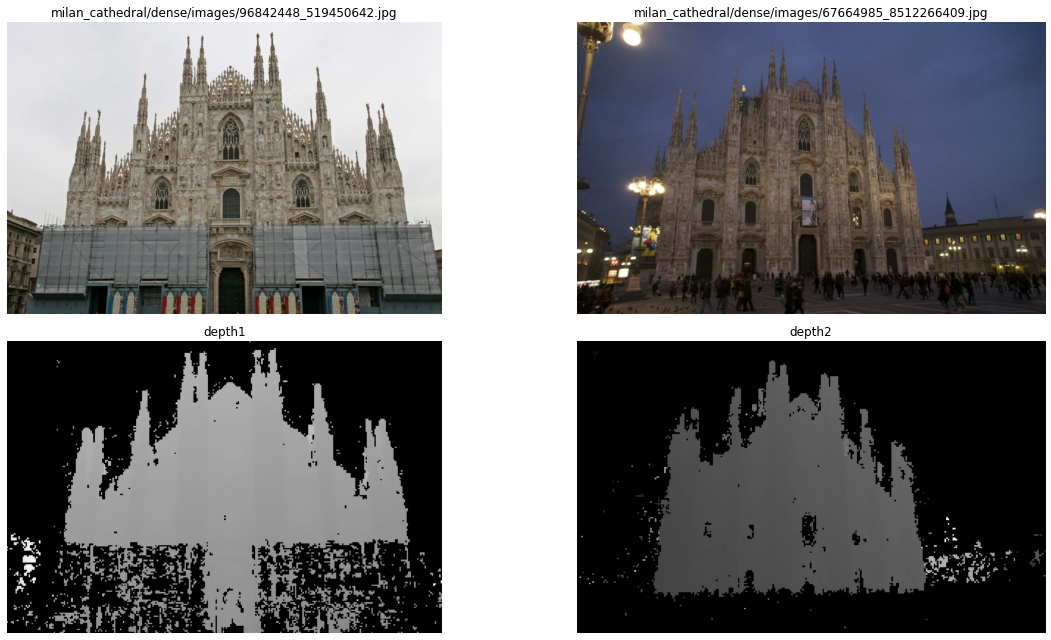

In [12]:
idx = 0

image1 = batch[du.IMAGE1]
image2 = batch[du.IMAGE2]

figures = {f"{batch[du.IMAGE_NAME1][idx]}": torch2cv(image1[idx]),
           f"{batch[du.IMAGE_NAME2][idx]}": torch2cv(image2[idx])}

if du.DEPTH1 in batch:
    figures[du.DEPTH1] = torch2cv(batch[du.DEPTH1][idx], normalize=True)
    figures[du.DEPTH2] = torch2cv(batch[du.DEPTH2][idx], normalize=True)

plot_figures(figures, len(figures) // 2, 2, (18, 9))

In [13]:
kp1 = endpoint[eu.KP1]
kp2 = endpoint[eu.KP2]

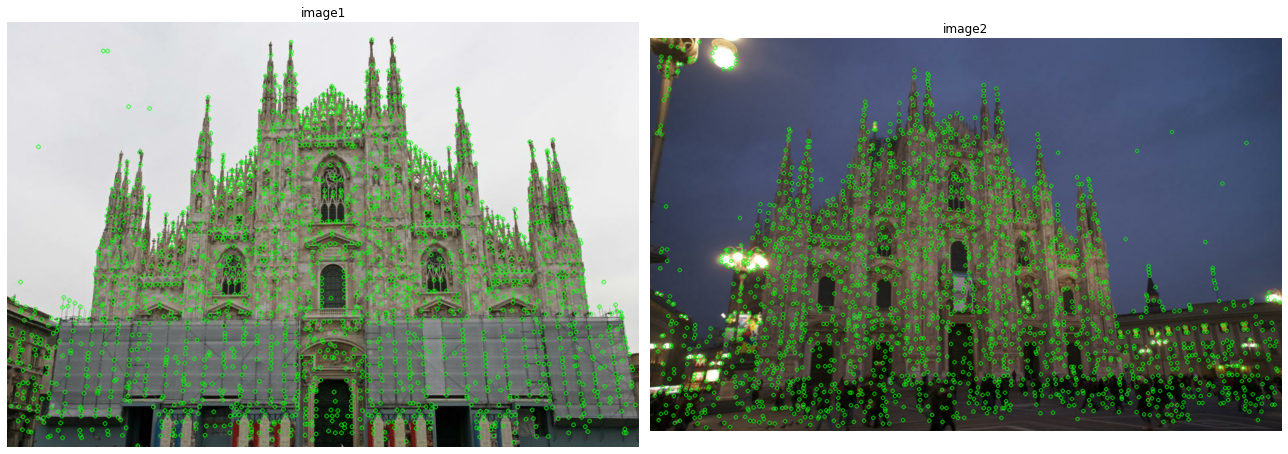

In [14]:
plot_figures({'image1': draw_cv_keypoints(image1, kp1),
              'image2': draw_cv_keypoints(image2, kp2)}, 1, 2, (18, 9))

In [28]:
shift_scale1 = batch[du.SHIFT_SCALE1]
shift_scale2 = batch[du.SHIFT_SCALE2]

if du.INTRINSICS1 in batch:
    intrinsics1 = batch[du.INTRINSICS1]
    intrinsics2 = batch[du.INTRINSICS2]

    extrinsics1 = batch[du.EXTRINSICS1]
    extrinsics2 = batch[du.EXTRINSICS2]
    
if du.H1 in batch:
    h1 = batch[du.H1]

In [29]:
mme_params = experiment.main_loop.model_mode_wrapper.model_mode_eval_params

## Feature matching

In [30]:
from source.pose.matchers.factory import instantiate_matcher
from source.evaluation.utils import get_kp_desc_and_kp_desc_mask

matcher = instantiate_matcher(mme_params, experiment.device)

kp_desc1, kp_desc2, kp_desc_mask1, kp_desc_mask2 = get_kp_desc_and_kp_desc_mask(endpoint)

mm_desc_mask1, nn_desc_idx1 = matcher.match(kp_desc1, kp_desc2, kp_desc_mask1, kp_desc_mask2)

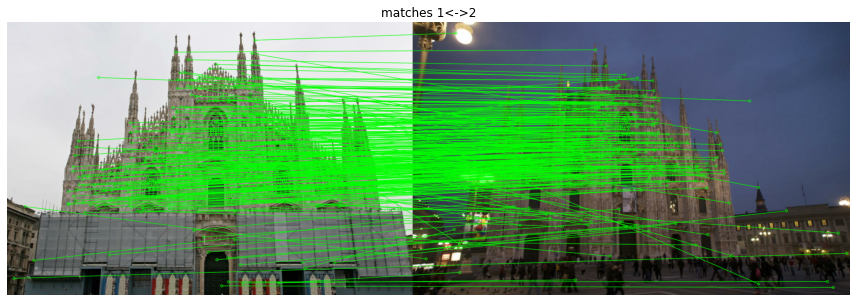

In [31]:
cv_image12_matches = draw_cv_matches(image1, image2, 
                                     kp1, kp2,
                                     nn_desc_idx1, mm_desc_mask1)

plot_figures({'matches 1<->2': cv_image12_matches}, 1, 1, (12, 10))

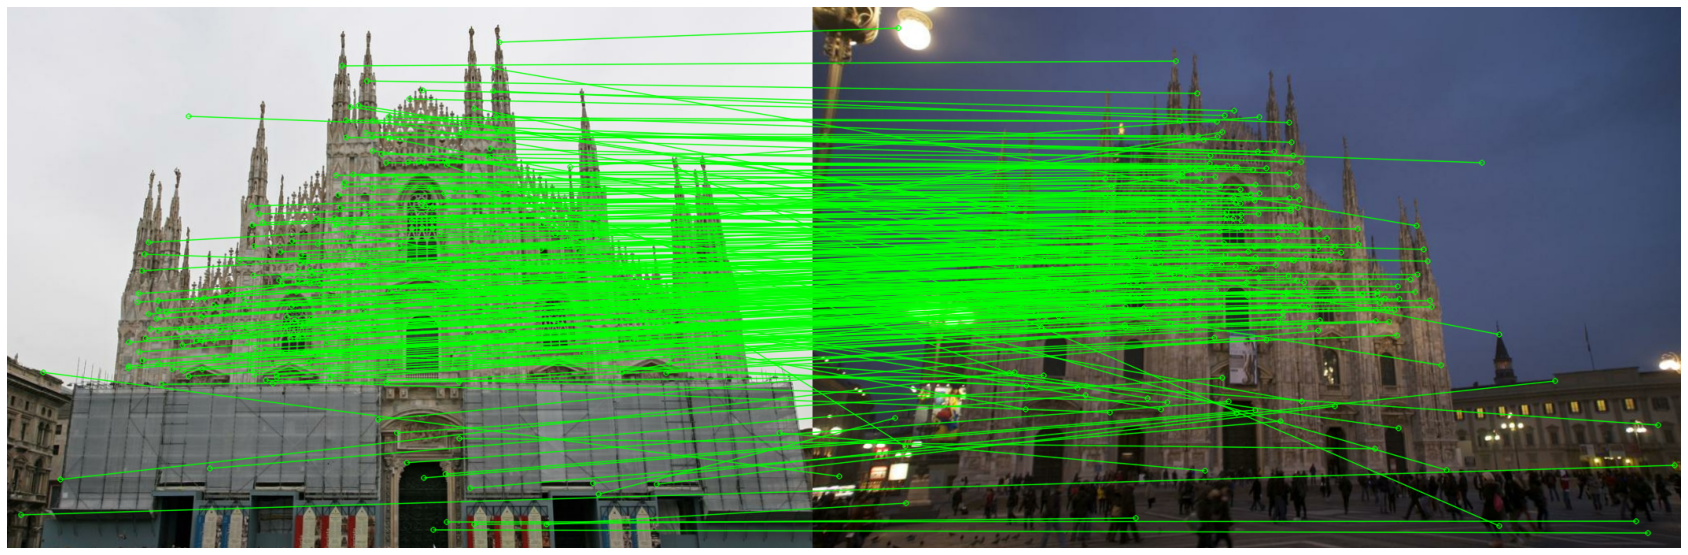

In [35]:
plt.figure(figsize =(30, 30))
plt.imshow(cv_image12_matches)
plt.axis('off')
plt.savefig('check3.png', bbox_inches='tight')

## Pose estimation

In [27]:
import source.pose.estimators.namespace as est_ns

from source.pose.estimators.fund_mat import FundMatEstimator
from source.pose.estimators.ess_mat import EssMatEstimator
from source.pose.estimators.homography import HomographyEstimator
from source.pose.estimators.utils import revert_shift_scale
from source.evaluation.rel_pose.metrics import relative_pose_error, relative_pose_error_from_homography
from source.pose.matchers.utils import gather_kp


_kp1, _kp2 = revert_shift_scale(endpoint[eu.KP1], shift_scale1), revert_shift_scale(endpoint[eu.KP2], shift_scale2)
nn_kp2 = gather_kp(_kp2, nn_desc_idx1.cpu())

estimator_name = mme_params.estimator.name

if estimator_name in [est_ns.F_PYDEGENSAC, est_ns.E_PYOPENGV]:
    if estimator_name == est_ns.F_PYDEGENSAC:
        estimator = FundMatEstimator.from_config(mme_params)
    
    elif estimator_name == est_ns.E_PYOPENGV:
        estimator = EssMatEstimator.from_config(mme_params)
    
    T12, inl_mask, success = estimator.estimate(_kp1[0].numpy(), nn_kp2[0].numpy(),
                                               mm_desc_mask1[0].cpu().numpy(),
                                               batch[du.INTRINSICS1][0].numpy(), batch[du.INTRINSICS2][0].numpy())
    
    r_err, t_err = relative_pose_error(T12[None], success,
                                       batch[du.EXTRINSICS1].numpy(), batch[du.EXTRINSICS2].numpy())

elif estimator_name in [est_ns.H_PYDEGENSAC, est_ns.H_OPENCV]:
    estimator = HomographyEstimator.from_config(mme_params)
    
    T12, inl_mask, success = estimator.estimate(_kp1[0].numpy(), nn_kp2[0].numpy(),
                                                mm_desc_mask1[0].cpu().numpy())
    
    r_err, t_err = relative_pose_error_from_homography(T12, inl_mask, success,
                                                       _kp1[0].numpy(), nn_kp2[0].numpy(),
                                                       batch[du.H1][0].numpy())

In [28]:
print('R err:', r_err.mean(-1).item())
print('t err:', t_err.mean(-1).item())
print("Num inliers:", inl_mask.sum(-1).mean().item())


R err: 2.1052896252514866
t err: 15.438116714339234
Num inliers: 282.0


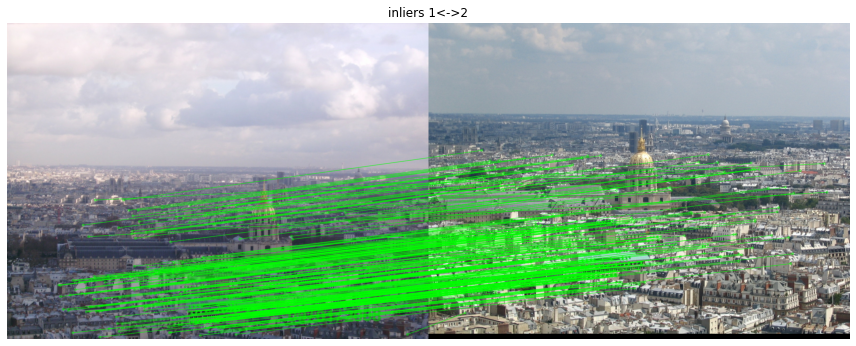

In [29]:
cv_image12_inliers = draw_cv_matches(image1, image2, 
                                     endpoint[eu.KP1], endpoint[eu.KP2], nn_desc_idx1,
                                     inl_mask[None])

plot_figures({'inliers 1<->2': cv_image12_inliers}, 1, 1, (12, 10))

## Repeatability score

In [30]:
from source.datasets.base.utils import HDataWrapper
from source.evaluation.classical.metrics import repeatability_score

if du.H1 in batch:
    h_data = HDataWrapper().init_from_batch(batch, torch.device('cpu'))
    
    rep = repeatability_score(kp1, kp2,
                              h_data,
                              torch.range(1, 10))
    
    print(rep)

## Mean matcing accuracy

In [31]:
from source.datasets.base.utils import HDataWrapper
from source.evaluation.classical.metrics import mean_matching_accuracy

if du.H1 in batch:
    h_data = HDataWrapper().init_from_batch(batch, torch.device('cpu'))
    
    mma = mean_matching_accuracy(kp1, kp2,
                                 kp_desc1, kp_desc2,
                                 kp_desc_mask1, kp_desc_mask2,
                                 matcher, h_data,
                                 torch.range(1, 10))
    
    print(mma)